<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Onri's_Custom_LLG_%2B_Thermal_Transport_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
export LC_ALL=C.UTF-8
export LANG=C.UTF-8
pip uninstall -y cupy cupy-cuda11x cupy-cuda12x

In [ ]:
!pip install cupy-cuda12x

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
!nvidia-smi

In [5]:
# 0) SETUP & IMPORTS
##############################
# If using Google Colab or a fresh environment:
# !pip install cupy-cuda12x
# (Adjust to match your CUDA version: 11x, 12x, etc.)
# Then restart runtime if asked.

import matplotlib.pyplot as plt

# Increase plot quality and animation embed limit for Colab.
plt.rcParams['figure.dpi'] = 250
plt.rcParams['animation.embed_limit'] = 100

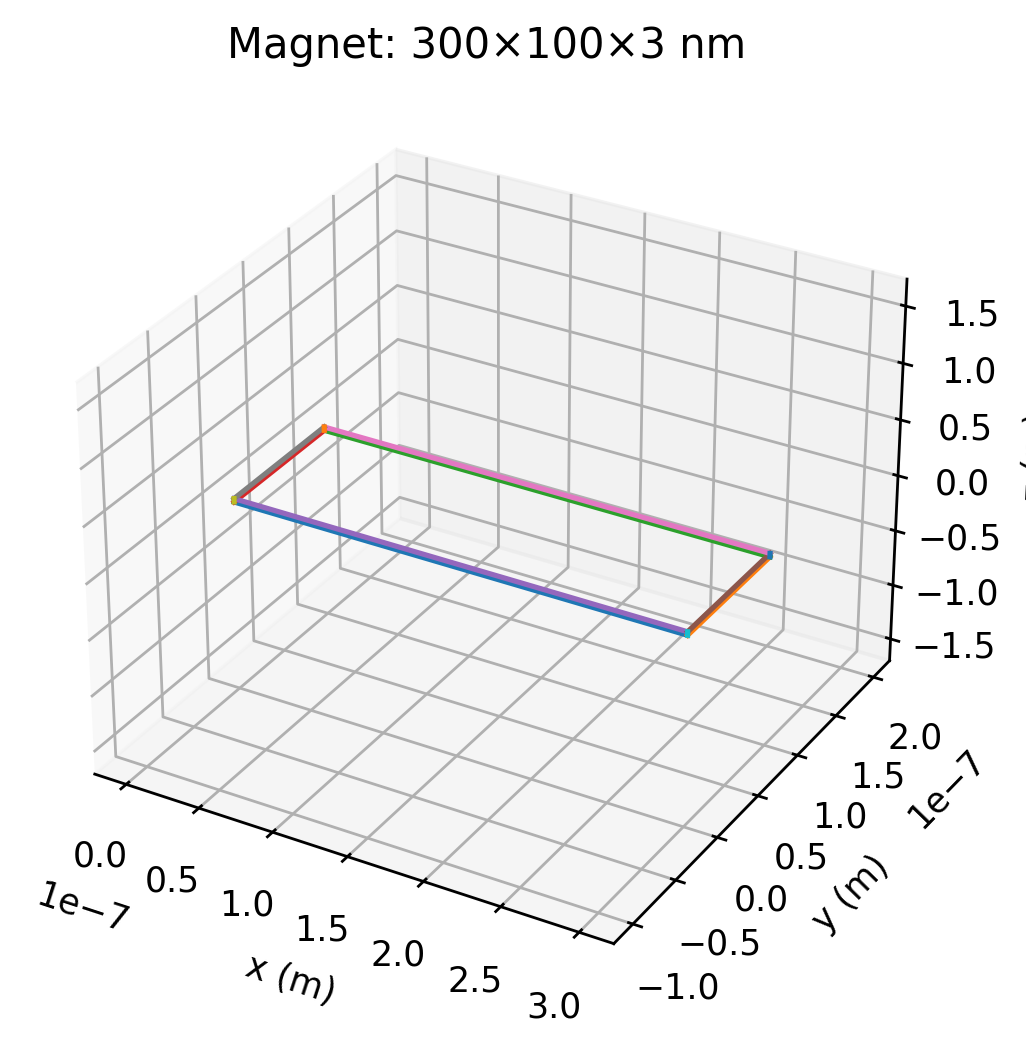

[T=0.001K] Step 0/201: B=-100.00 mT, Mx=-7.31e+05 A/m
[T=0.001K] Step 40/201: B=-20.00 mT, Mx=-6.88e+05 A/m
[T=0.001K] Step 80/201: B=60.00 mT, Mx=7.19e+05 A/m
[T=0.001K] Step 120/201: B=60.00 mT, Mx=7.19e+05 A/m
[T=0.001K] Step 160/201: B=-20.00 mT, Mx=-6.87e+05 A/m
[T=0.001K] Step 200/201: B=-100.00 mT, Mx=-7.31e+05 A/m
[T=0.005K] Step 0/201: B=-100.00 mT, Mx=-6.80e+05 A/m
[T=0.005K] Step 40/201: B=-20.00 mT, Mx=-4.44e+05 A/m
[T=0.005K] Step 80/201: B=60.00 mT, Mx=6.45e+05 A/m
[T=0.005K] Step 120/201: B=60.00 mT, Mx=6.43e+05 A/m
[T=0.005K] Step 160/201: B=-20.00 mT, Mx=-4.37e+05 A/m
[T=0.005K] Step 200/201: B=-100.00 mT, Mx=-6.80e+05 A/m
[T=0.01K] Step 0/201: B=-100.00 mT, Mx=-6.18e+05 A/m
[T=0.01K] Step 40/201: B=-20.00 mT, Mx=-2.47e+05 A/m
[T=0.01K] Step 80/201: B=60.00 mT, Mx=5.32e+05 A/m
[T=0.01K] Step 120/201: B=60.00 mT, Mx=5.30e+05 A/m
[T=0.01K] Step 160/201: B=-20.00 mT, Mx=-2.42e+05 A/m
[T=0.01K] Step 200/201: B=-100.00 mT, Mx=-6.18e+05 A/m
[T=0.02K] Step 0/201: B=-100.00 mT

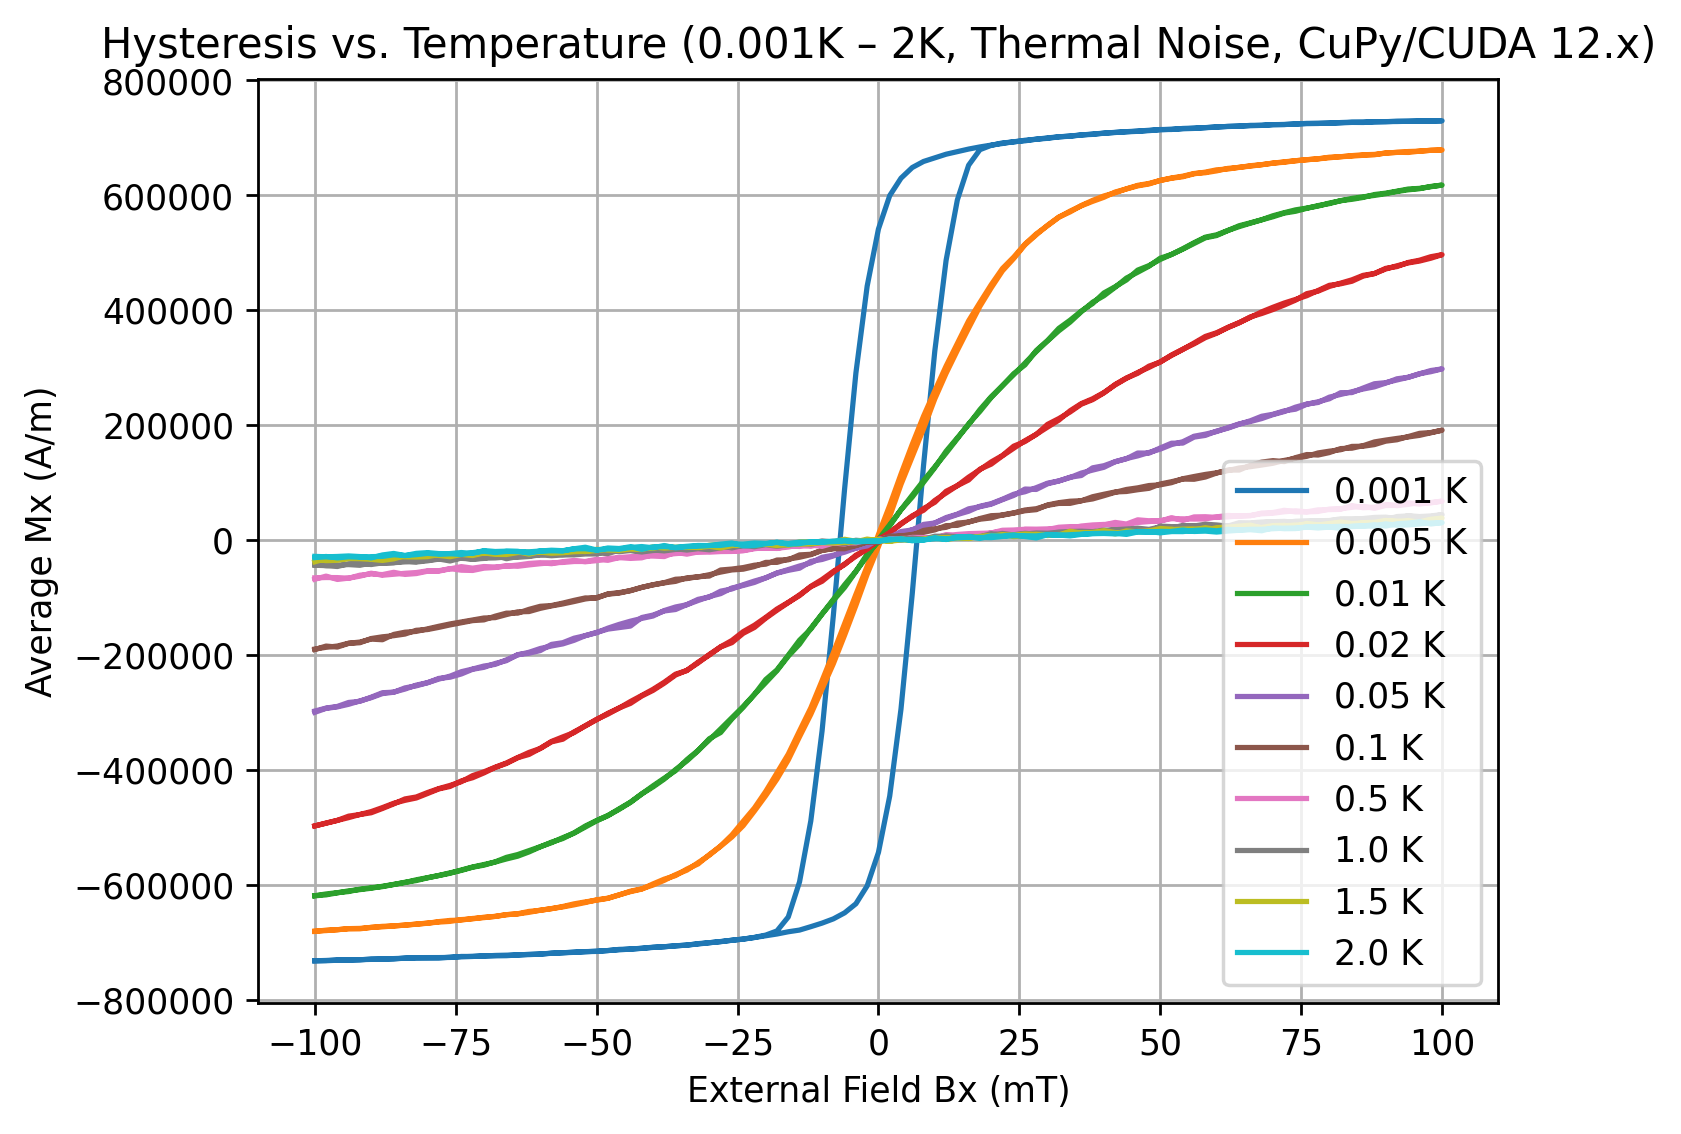

In [4]:
#  SINGLE-CELL COLAB SCRIPT
# ==========================

# (Optional) If Colab doesn't have CuPy (CUDA 12.x) installed yet, uncomment:
# !pip install cupy-cuda12x

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Increase plot quality (for Colab).
plt.rcParams['figure.dpi'] = 250
plt.rcParams['animation.embed_limit'] = 100

###############################################################################
# 1) HELPER FUNCTIONS: DRAW 3D BOX & EQUAL AXES
###############################################################################
def draw_box_3d(ax, xlen, ylen, zlen):
    corners = np.array([
        [0,     0,     0    ],
        [xlen,  0,     0    ],
        [xlen,  ylen,  0    ],
        [0,     ylen,  0    ],
        [0,     0,     zlen ],
        [xlen,  0,     zlen ],
        [xlen,  ylen,  zlen ],
        [0,     ylen,  zlen ],
    ])
    edges = [
        (0,1), (1,2), (2,3), (3,0),  # bottom face
        (4,5), (5,6), (6,7), (7,4),  # top face
        (0,4), (1,5), (2,6), (3,7)   # vertical edges
    ]
    for e in edges:
        p1, p2 = corners[e[0]], corners[e[1]]
        ax.plot3D(*zip(p1, p2))

def set_axes_equal_3d(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]
    max_range = max(x_range, y_range, z_range)

    x_mid = 0.5 * (x_limits[0] + x_limits[1])
    y_mid = 0.5 * (y_limits[0] + y_limits[1])
    z_mid = 0.5 * (z_limits[0] + z_limits[1])

    ax.set_xlim3d([x_mid - 0.5*max_range, x_mid + 0.5*max_range])
    ax.set_ylim3d([y_mid - 0.5*max_range, y_mid + 0.5*max_range])
    ax.set_zlim3d([z_mid - 0.5*max_range, z_mid + 0.5*max_range])

###############################################################################
# 2) SIMULATION PARAMETERS
###############################################################################
Nx, Ny, Nz = 300, 100, 3
dx, dy, dz = 1e-9, 1e-9, 1e-9

lx, ly, lz = Nx*dx, Ny*dy, Nz*dz  # total size in meters

# Material parameters
Ms    = 8.0e5       # A/m
Aex   = 1.3e-11     # J/m
alpha = 0.05        # damping
gamma = 2.211e5     # gyromagnetic ratio (m/As)
mu0   = 4e-7 * np.pi
Ku    = 2.0e4       # uniaxial anisotropy, J/m^3

# Time integration
dt_relax      = 5e-15
relax_substeps= 30

# Field sweeps
Bmax = 0.1
dB   = 0.002
B_values_up   = np.arange(-Bmax, Bmax + 1e-12, dB)
B_values_down = np.arange(Bmax - dB, -Bmax - 1e-12, -dB)
B_values = np.concatenate([B_values_up, B_values_down])

k_B = 1.380649e-23
cell_volume = dx * dy * dz

###############################################################################
# 3) VISUALIZE THE GEOMETRY
###############################################################################
fig_geom = plt.figure()
ax_geom = fig_geom.add_subplot(projection='3d')
draw_box_3d(ax_geom, lx, ly, lz)
ax_geom.set_xlabel('x (m)')
ax_geom.set_ylabel('y (m)')
ax_geom.set_zlabel('z (m)')
ax_geom.set_title(f"Magnet: {lx*1e9:.0f}×{ly*1e9:.0f}×{lz*1e9:.0f} nm")
set_axes_equal_3d(ax_geom)
plt.show()

###############################################################################
# 4) INITIAL MAGNETIZATION
###############################################################################
m0 = cp.random.uniform(-1.0, 1.0, size=(3, Nx, Ny, Nz))
norms = cp.sqrt(cp.sum(m0**2, axis=0))
norms = cp.where(norms < 1e-30, 1.0, norms)
m0 /= norms

###############################################################################
# 5) DEMAG (FFT) SETUP
###############################################################################
kx = cp.fft.fftfreq(Nx, d=dx)
ky = cp.fft.fftfreq(Ny, d=dy)
kz = cp.fft.fftfreq(Nz, d=dz)

KX, KY, KZ = cp.meshgrid(kx, ky, kz, indexing='ij')
k2 = KX**2 + KY**2 + KZ**2
k2 = cp.where(k2 < 1e-30, 1.0, k2)

Nxx = KX**2 / k2
Nyy = KY**2 / k2
Nzz = KZ**2 / k2
Nxy = KX*KY / k2
Nxz = KX*KZ / k2
Nyz = KY*KZ / k2

Nxx[0,0,0] = 0
Nyy[0,0,0] = 0
Nzz[0,0,0] = 0
Nxy[0,0,0] = 0
Nxz[0,0,0] = 0
Nyz[0,0,0] = 0

def demag_field(mag):
    m_kx = cp.fft.fftn(mag[0], axes=(0,1,2))
    m_ky = cp.fft.fftn(mag[1], axes=(0,1,2))
    m_kz = cp.fft.fftn(mag[2], axes=(0,1,2))

    Hx_k = -Ms * (Nxx*m_kx + Nxy*m_ky + Nxz*m_kz)
    Hy_k = -Ms * (Nxy*m_kx + Nyy*m_ky + Nyz*m_kz)
    Hz_k = -Ms * (Nxz*m_kx + Nyz*m_ky + Nzz*m_kz)

    Hx = cp.fft.ifftn(Hx_k, axes=(0,1,2)).real
    Hy = cp.fft.ifftn(Hy_k, axes=(0,1,2)).real
    Hz = cp.fft.ifftn(Hz_k, axes=(0,1,2)).real
    return cp.stack((Hx, Hy, Hz), axis=0)

###############################################################################
# 6) EXCHANGE
###############################################################################
def laplacian_3d(vec):
    out = cp.zeros_like(vec)
    for c in range(3):
        f = vec[c]
        fxx = cp.roll(f, 1, axis=0) + cp.roll(f, -1, axis=0) - 2*f
        fyy = cp.roll(f, 1, axis=1) + cp.roll(f, -1, axis=1) - 2*f
        if Nz > 1:
            fzz = cp.roll(f, 1, axis=2) + cp.roll(f, -1, axis=2) - 2*f
        else:
            fzz = 0
        out[c] = (fxx + fyy + fzz) / (dx**2)
    return out

def exchange_field(mag):
    coef = 2.0 * Aex / (mu0 * Ms**2)
    return coef * laplacian_3d(mag)

###############################################################################
# 7) UNAXIAL ANISOTROPY
###############################################################################
def anisotropy_field(mag):
    mx = mag[0]
    coeff = 2.0 * Ku / (mu0 * Ms)
    Hx = coeff * mx
    Hy = cp.zeros_like(mx)
    Hz = cp.zeros_like(mx)
    return cp.stack((Hx, Hy, Hz), axis=0)

###############################################################################
# 8) THERMAL NOISE
###############################################################################
def thermal_field(T):
    if T < 1e-10:
        return cp.zeros((3, Nx, Ny, Nz))
    sigma = cp.sqrt(
        (2.0 * alpha * k_B * T) /
        (mu0 * gamma * Ms * cell_volume * dt_relax)
    )
    return sigma * cp.random.normal(size=(3, Nx, Ny, Nz))

###############################################################################
# 9) LLG (with Thermal Term)
###############################################################################
def llg_rhs(mag, Hx, T):
    H_ext = cp.zeros_like(mag)
    H_ext[0] = Hx

    H_dem = demag_field(mag)
    H_ex  = exchange_field(mag)
    H_ani = anisotropy_field(mag)
    H_th  = thermal_field(T)

    H_eff = H_ext + H_dem + H_ex + H_ani + H_th

    cross_mH = cp.cross(mag.transpose(1,2,3,0), H_eff.transpose(1,2,3,0), axis=3)
    cross_mH = cross_mH.transpose(3,0,1,2)
    dm_dt_precess = - gamma * cross_mH

    cross_m_dm = cp.cross(mag.transpose(1,2,3,0), dm_dt_precess.transpose(1,2,3,0), axis=3)
    cross_m_dm = cross_m_dm.transpose(3,0,1,2)
    dm_dt_damp = alpha * gamma * cross_m_dm

    return dm_dt_precess + dm_dt_damp

def llg_heun_step(mag, Hx, dt, T):
    k1 = llg_rhs(mag, Hx, T)
    m_tilde = mag + dt*k1

    lens_tilde = cp.sqrt(cp.sum(m_tilde**2, axis=0))
    lens_tilde = cp.where(lens_tilde < 1e-30, 1.0, lens_tilde)
    m_tilde /= lens_tilde

    k2 = llg_rhs(m_tilde, Hx, T)
    m_new = mag + 0.5*dt*(k1 + k2)

    lens_new = cp.sqrt(cp.sum(m_new**2, axis=0))
    lens_new = cp.where(lens_new < 1e-30, 1.0, lens_new)
    m_new /= lens_new

    return m_new

###############################################################################
# 10) SWEEP FIELDS AT MULTIPLE TEMPERATURES
###############################################################################
# Updated T_list: from 0.001K up to 2K, including 0.01K
T_list = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]

all_hyst_data = {}
for T in T_list:
    m_local = m0.copy()
    mx_vals = []
    field_vals = []

    for i, Bx in enumerate(B_values):
        Hx_am = Bx / mu0
        for _ in range(relax_substeps):
            m_local = llg_heun_step(m_local, Hx_am, dt_relax, T)

        mx_avg = (cp.mean(m_local[0]) * Ms).get()
        mx_vals.append(mx_avg)
        field_vals.append(Bx)

        if i % 40 == 0:
            print(f"[T={T}K] Step {i}/{len(B_values)}: "
                  f"B={Bx*1e3:.2f} mT, Mx={mx_avg:.2e} A/m")

    all_hyst_data[T] = (np.array(field_vals), np.array(mx_vals))

###############################################################################
# 11) PLOT RESULTS: Mx (A/m) vs. B (mT)
###############################################################################
plt.figure()
for T in T_list:
    fvals, mxvals = all_hyst_data[T]
    plt.plot(fvals * 1e3, mxvals, label=f"{T} K")

plt.xlabel("External Field Bx (mT)")
plt.ylabel("Average Mx (A/m)")
plt.title("Hysteresis vs. Temperature (0.001K – 2K, Thermal Noise, CuPy/CUDA 12.x)")
plt.grid(True)
plt.legend()
plt.show()
